# RNA velocity in adult mouse brain

RNA velocity analysis with the *VI model* using data preprocessed with `velocyto`.

**Requires**

* `adata_generation.ipynb`

**Output**

* `velocyto_var_names.csv`
* `DATA_DIR/old_brain/velocities/velocyto_velovi.npy`

## Library imports

In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from velovi import preprocess_data, VELOVI

sys.path.insert(0, "../../../")
from paths import DATA_DIR

Global seed set to 0


In [2]:
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2022-07-19 21:10.


## General settings

In [3]:
scvi.settings.dl_pin_memory_gpu_training = False

In [4]:
# set verbosity levels
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [5]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

## Function definitions

In [6]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

## Data loading

Load the AnnData object from the CellRank software package (or from whereever you would like to load your data from)

In [7]:
adata = sc.read(DATA_DIR / 'old_brain' / "velocyto.h5ad")
adata

AnnData object with n_obs × n_vars = 1823 × 54143
    obs: 'cell_index', 'clusters_coarse', 'clusters', 'NAME', 'nGene', 'nUMI', 'animal_type', 'cell_type_age'
    layers: 'spliced', 'unspliced'

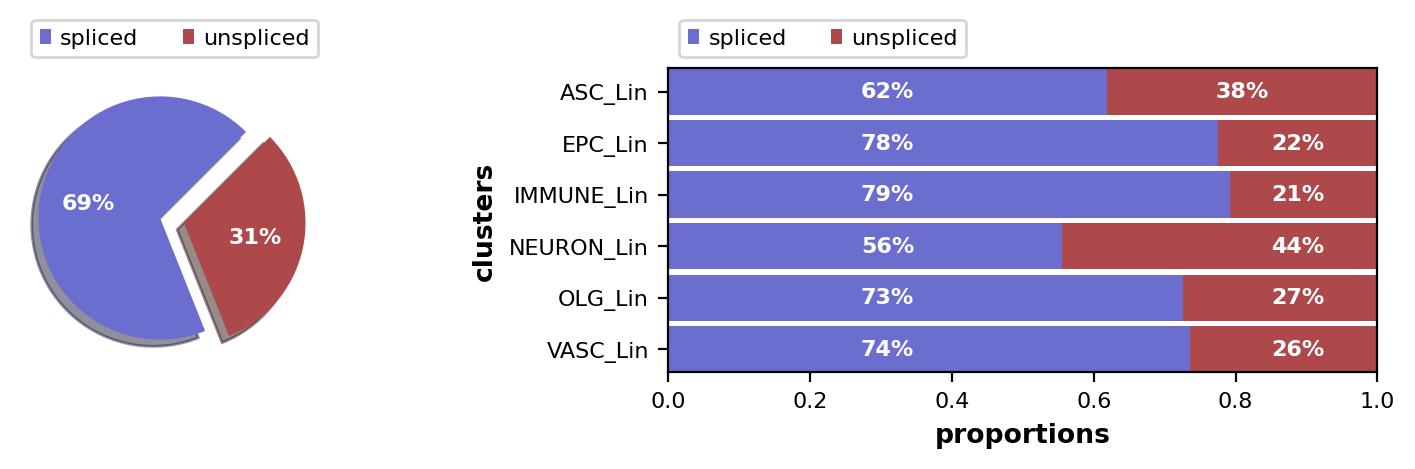

In [8]:
scv.pl.proportions(adata)

## Data pre-processing

In [9]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata = preprocess_data(adata)

Filtered out 49315 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:02)
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [10]:
# Save used variables
adata.var.to_csv('velocyto_var_names.csv', columns=[], header=False)

## Model fitting

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:18<00:00,  6.34it/s, loss=-6.46e+03, v_num=1]


VELOVI Model with the following params: 
n_hidden: 256, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

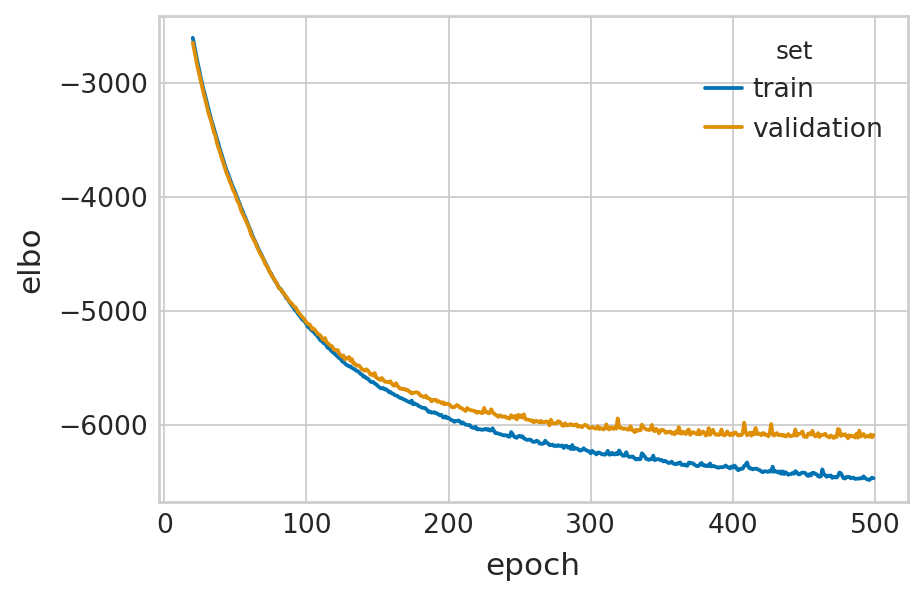

In [11]:
fit_velovi(adata)

### Save results

In [12]:
os.makedirs(DATA_DIR / 'old_brain' / 'velocities', exist_ok=True)
np.save(
    file=DATA_DIR / 'old_brain' / 'velocities' / 'velocyto_velovi.npy', arr=adata.layers['velocities_velovi']
)